In [22]:
## Can also get the price chart by pokemon number, or url for past prices. Look intro trading strategies; also, work on real-time offering feed vs history. 

In [23]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import re

# Customize number of pages to scrape
num_pages = 14
"""Can adjust filter to be for specific set or, type, quality, pokemon, etc. Using the link. 
"""
# Black bolt: https://www.tcgplayer.com/search/pokemon/sv-black-bolt?productLineName=pokemon&page={}&view=grid&setName=sv-black-bolt&CardType=Pokemon
#base_url:'https://www.tcgplayer.com/search/pokemon/sv-black-bolt?productLineName=pokemon&page={}&setName=sv-black-bolt&CardType=Pokemon'
base_url = 'https://www.tcgplayer.com/search/pokemon/sv-black-bolt?productLineName=pokemon&page={}&setName=sv-black-bolt&CardType=Pokemon'
# Setup headless Chrome options
options = Options()
options.add_argument("--headless=new")
prefs = {"profile.default_content_setting_values": {"images": 2, "stylesheets": 2}}
options.add_experimental_option("prefs", prefs)

def scrape_page(page_num):
    driver = webdriver.Chrome(options=options)
    wait = WebDriverWait(driver, 10)
    url = base_url.format(page_num)
    driver.get(url)

    try:
        wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "product-card__product")))
    except:
        driver.quit()
        return []

    products = driver.find_elements(By.CLASS_NAME, "product-card__product")
    results = []

    for product in products:
        try:
            # Grab the link directly from the <a> tag
            link_elem = product.find_element(By.XPATH, "./ancestor::a")
            product_link = link_elem.get_attribute("href")
        except Exception:
            product_link = None

        try:
            img_elem = product.find_element(By.TAG_NAME, "img")
            name = img_elem.get_attribute("alt").strip()
        except Exception:
            name = None

        try:
            set_name = product.find_element(By.CLASS_NAME, "product-card__set-name__variant").text.strip()
        except Exception:
            set_name = None

        try:
            mktprice_text = product.find_element(By.CLASS_NAME, "product-card__market-price--value").text.strip()
            mktprice_match = re.search(r"\$([\d,.]+)", mktprice_text)
            mktprice = float(mktprice_match.group(1).replace(",", "")) if mktprice_match else None
        except Exception:
            mktprice = None

        try:
            listings_span = product.find_element(By.CLASS_NAME, "inventory__listing-count").text.strip()
            listings_match = re.search(r"(\d+)\s+listings", listings_span)
            listings = int(listings_match.group(1)) if listings_match else None
        except Exception:
            listings = None

        results.append({
            "name": name,
            "link": product_link,
            "set": set_name,
            "mktprice": mktprice,
            "listings": listings
        })

    driver.quit()
    return results

# Run across multiple pages
all_results = []
with ThreadPoolExecutor(max_workers=6) as executor:
    futures = [executor.submit(scrape_page, p) for p in range(1, num_pages + 1)]
    for future in as_completed(futures):
        all_results.extend(future.result())

# Convert to DataFrame
pricedf = pd.DataFrame(all_results)
print(pricedf)


                                        name  \
0                          Servine - 088/086   
1                            Throh - 128/086   
2                          Petilil - 091/086   
3                                    Bisharp   
4                          Timburr - 125/086   
..                                       ...   
187            Crustle (Master Ball Pattern)   
188          Lilligant (Master Ball Pattern)   
189           Krokorok (Master Ball Pattern)   
190  Unova Mini Tin [Krookodile & Excadrill]   
191          Reuniclus (Master Ball Pattern)   

                                                  link             set  \
0    https://www.tcgplayer.com/product/642537/pokem...  SV: Black Bolt   
1    https://www.tcgplayer.com/product/642583/pokem...  SV: Black Bolt   
2    https://www.tcgplayer.com/product/642540/pokem...  SV: Black Bolt   
3    https://www.tcgplayer.com/product/642516/pokem...  SV: Black Bolt   
4    https://www.tcgplayer.com/product/642580/pokem..

In [24]:
pricedf

,name,link,set,mktprice,listings
0,Servine - 088/086,https://www.tcgplayer.com/product/642537/pokem...,SV: Black Bolt,12.50,45.0
1,Throh - 128/086,https://www.tcgplayer.com/product/642583/pokem...,SV: Black Bolt,5.48,64.0
2,Petilil - 091/086,https://www.tcgplayer.com/product/642540/pokem...,SV: Black Bolt,9.31,44.0
3,Bisharp,https://www.tcgplayer.com/product/642516/pokem...,SV: Black Bolt,0.05,493.0
4,Timburr - 125/086,https://www.tcgplayer.com/product/642580/pokem...,SV: Black Bolt,6.72,49.0
...,...,...,...,...,...
187,Crustle (Master Ball Pattern),https://www.tcgplayer.com/product/642673/pokem...,SV: Black Bolt,14.20,34.0
188,Lilligant (Master Ball Pattern),https://www.tcgplayer.com/product/642629/pokem...,SV: Black Bolt,8.85,27.0
189,Krokorok (Master Ball Pattern),https://www.tcgplayer.com/product/642679/pokem...,SV: Black Bolt,7.45,32.0
190,Unova Mini Tin [Krookodile & Excadrill],https://www.tcgplayer.com/product/630440/pokem...,SV: Black Bolt,21.42,32.0


In [29]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pandas as pd

options = Options()
# Keep browser visible but optimize resource use
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--window-size=1280,800")

prefs = {"profile.default_content_setting_values": {"images": 2, "stylesheets": 2}}
options.add_experimental_option("prefs", prefs)

def scrape_product_page(url):
    driver = webdriver.Chrome(options=options)
    wait = WebDriverWait(driver, 30)  # reduced wait time for efficiency
    driver.get(url)
    try:
        table = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table[role='region'][aria-live='polite']")))
        html_content = table.get_attribute("outerHTML")
    except Exception as e:
        print("Table not found or failed to load:", e)
        html_content = None
    driver.quit()
    return html_content

if 'pricedf' in globals() and not pricedf.empty and pd.notna(pricedf.loc[0, "link"]):
    first_link = pricedf.loc[0, "link"]
    html = scrape_product_page(first_link)
    if html:
        print(html)
    else:
        print("Failed to scrape table HTML content.")
else:
    print("No valid link found in pricedf.")
    
from bs4 import BeautifulSoup
# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html, "html.parser")

# Locate the table containing historical price data
price_table = soup.find("table", {"role": "region", "aria-live": "polite"})

# Extract rows from the table
rows = price_table.find_all("tr")[1:]  # Skip header row

# Parse each row into structured data
price_history = []
for row in rows:
    cells = row.find_all("td")
    if len(cells) >= 3:
        date_range = cells[0].get_text(strip=True)
        normal_price = cells[1].get_text(strip=True)
        alt_price = cells[2].get_text(strip=True)
        price_history.append({
            "Date Range": date_range,
            "Normal Price": normal_price,
            "Volume": alt_price 
        })

# Convert to DataFrame for analysis or export
import pandas as pd
history_df = pd.DataFrame(price_history)

# Display the result
print(history_df)

<table data-v-8daf4e1f="" role="region" aria-live="polite"><thead data-v-8daf4e1f=""><tr data-v-8daf4e1f=""><th data-v-8daf4e1f="">Date</th><th data-v-8daf4e1f="">Holofoil</th></tr></thead><tbody data-v-8daf4e1f=""><tr data-v-8daf4e1f=""><td data-v-8daf4e1f="">5/19 to 5/21</td><td data-v-8daf4e1f="">$0.00</td><td data-v-8daf4e1f="">$0.00</td></tr><tr data-v-8daf4e1f=""><td data-v-8daf4e1f="">5/22 to 5/24</td><td data-v-8daf4e1f="">$0.00</td><td data-v-8daf4e1f="">$0.00</td></tr><tr data-v-8daf4e1f=""><td data-v-8daf4e1f="">5/25 to 5/27</td><td data-v-8daf4e1f="">$0.00</td><td data-v-8daf4e1f="">$0.00</td></tr><tr data-v-8daf4e1f=""><td data-v-8daf4e1f="">5/28 to 5/30</td><td data-v-8daf4e1f="">$0.00</td><td data-v-8daf4e1f="">$0.00</td></tr><tr data-v-8daf4e1f=""><td data-v-8daf4e1f="">5/31 to 6/2</td><td data-v-8daf4e1f="">$0.00</td><td data-v-8daf4e1f="">$0.00</td></tr><tr data-v-8daf4e1f=""><td data-v-8daf4e1f="">6/3 to 6/5</td><td data-v-8daf4e1f="">$0.00</td><td data-v-8daf4e1f=""

In [30]:
# Filter parameters
#name_value = "Example Name"
#set_value = "Example Set"
min_mktprice = 10
max_mktprice = 300
min_listings = 10
max_listings = 20000

# Apply filters
filterdf = pricedf[
#    (pricedf["name"] == name_value) &
#    (pricedf["set"] == set_value) &
    (pricedf["mktprice"] >= min_mktprice) &
    (pricedf["mktprice"] <= max_mktprice) &
    (pricedf["listings"] >= min_listings) &
    (pricedf["listings"] <= max_listings)
][["name", "link", "set", "mktprice", "listings"]]
filterdf

,name,link,set,mktprice,listings
0,Servine - 088/086,https://www.tcgplayer.com/product/642537/pokem...,SV: Black Bolt,12.50,45.0
12,Axew - 145/086,https://www.tcgplayer.com/product/642599/pokem...,SV: Black Bolt,12.18,72.0
23,Tynamo - 113/086,https://www.tcgplayer.com/product/642566/pokem...,SV: Black Bolt,14.62,26.0
27,Dwebble - 129/086,https://www.tcgplayer.com/product/642584/pokem...,SV: Black Bolt,25.96,11.0
39,Seismitoad - 105/086,https://www.tcgplayer.com/product/642558/pokem...,SV: Black Bolt,183.48,48.0
58,Unova Victini Illustration Collection,https://www.tcgplayer.com/product/630615/pokem...,SV: Black Bolt,39.41,131.0
62,Unova Poster Collection,https://www.tcgplayer.com/product/630612/pokem...,SV: Black Bolt,30.95,115.0
71,Black Bolt Binder Collection,https://www.tcgplayer.com/product/630430/pokem...,SV: Black Bolt,49.72,93.0
84,Emolga - 112/086,https://www.tcgplayer.com/product/642565/pokem...,SV: Black Bolt,12.08,17.0
92,Audino - 151/086,https://www.tcgplayer.com/product/642605/pokem...,SV: Black Bolt,11.56,52.0


In [34]:
filerdf = filterdf.head(2)

In [35]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd

options = Options()
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--window-size=1280,800")
prefs = {"profile.default_content_setting_values": {"images": 2, "stylesheets": 2}}
options.add_experimental_option("prefs", prefs)

def scrape_product_page(url):
    driver = webdriver.Chrome(options=options)
    wait = WebDriverWait(driver, 30)
    driver.get(url)
    try:
        table = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table[role='region'][aria-live='polite']")))
        html_content = table.get_attribute("outerHTML")
    except Exception as e:
        print("Table not found or failed to load:", e)
        html_content = None
    driver.quit()
    return html_content

def parse_numeric(value):
    value = value.replace("$", "").replace(",", "").strip()
    try:
        return int(value)
    except ValueError:
        try:
            return float(value)
        except ValueError:
            return 0  # or use pd.NA / np.nan for missing

def parse_price_history(html):
    soup = BeautifulSoup(html, "html.parser")
    price_table = soup.find("table", {"role": "region", "aria-live": "polite"})
    price_history = []
    if price_table:
        rows = price_table.find_all("tr")[1:]  # Skip header row
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 3:
                date_range = cells[0].get_text(strip=True)
                normal_price = parse_numeric(cells[1].get_text(strip=True))
                volume = parse_numeric(cells[2].get_text(strip=True))
                price_history.append({"date_range": date_range, "normal_price": normal_price, "volume": volume})
    return pd.DataFrame(price_history)

def convert_to_second_date(df):
    # Extract second date from date_range column and convert to datetime
    df['date'] = df['date_range'].str.split(' to ').str[1]
    current_year = pd.Timestamp.now().year
    df['date'] = pd.to_datetime(df['date'] + f'/{current_year}', format='%m/%d/%Y', errors='coerce')
    df.drop(columns=['date_range'], inplace=True)
    return df

# Main scraping and processing loop
history_list = []
for idx, row in filterdf.iterrows():
    html = scrape_product_page(row['link'])
    if html:
        hist_df = parse_price_history(html)
        if not hist_df.empty:
            hist_df = convert_to_second_date(hist_df)
            hist_df["name"] = row["name"]
            hist_df["set"] = row["set"]
            history_list.append(hist_df)

if history_list:
    setdf = pd.concat(history_list, ignore_index=True)
    combined = setdf.groupby("date").agg({"normal_price": "mean", "volume": "sum"}).reset_index()
else:
    setdf = pd.DataFrame()
    combined = pd.DataFrame()

print(setdf)
print(combined)


Table not found or failed to load: Message: stale element reference: stale element not found in the current frame
  (Session info: chrome=139.0.7258.128); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
0   chromedriver                        0x00000001047faef8 chromedriver + 5918456
1   chromedriver                        0x00000001047f248a chromedriver + 5883018
2   chromedriver                        0x00000001042bee20 chromedriver + 429600
3   chromedriver                        0x00000001042c5b23 chromedriver + 457507
4   chromedriver                        0x00000001042c884a chromedriver + 469066
5   chromedriver                        0x000000010435f18a chromedriver + 1085834
6   chromedriver                        0x0000000104336f12 chromedriver + 921362
7   chromedriver                        0x000000010435e024 chromedriver + 1081380
8   chromedriver            

In [39]:
setdf 

,normal_price,volume,date,name,set
0,0.00,0.0,2025-05-21,Servine - 088/086,SV: Black Bolt
1,0.00,0.0,2025-05-24,Servine - 088/086,SV: Black Bolt
2,0.00,0.0,2025-05-27,Servine - 088/086,SV: Black Bolt
3,0.00,0.0,2025-05-30,Servine - 088/086,SV: Black Bolt
4,0.00,0.0,2025-06-02,Servine - 088/086,SV: Black Bolt
...,...,...,...,...,...
655,21.97,2.0,2025-08-06,Unova Mini Tin [Krookodile & Excadrill],SV: Black Bolt
656,21.70,1.0,2025-08-09,Unova Mini Tin [Krookodile & Excadrill],SV: Black Bolt
657,21.62,2.0,2025-08-12,Unova Mini Tin [Krookodile & Excadrill],SV: Black Bolt
658,21.45,3.0,2025-08-15,Unova Mini Tin [Krookodile & Excadrill],SV: Black Bolt


In [53]:
# Assume `setdf` has columns: ['normal_price', 'volume', 'date', 'name', 'set']

# Step 1: Create separate columns for price and volume with the name embedded
setdf['price_col'] = setdf['name'] + " price"
setdf['volume_col'] = setdf['name'] + " volume"

# Step 2: Pivot to get price columns wide by date
price_pivot = setdf.pivot_table(index='date', columns='price_col', values='normal_price')

# Step 3: Pivot to get volume columns wide by date
volume_pivot = setdf.pivot_table(index='date', columns='volume_col', values='volume')

# Step 4: Combine price and volume pivots side by side by date
combined_df = pd.concat([price_pivot, volume_pivot], axis=1)

# Optional: sort columns alphabetically for clarity
combined_df = combined_df.reindex(sorted(combined_df.columns), axis=1)
# Assuming combined_df is your pivoted DataFrame with NaNs
combined_df = combined_df.bfill()

print(combined_df)


            Audino - 151/086 price  Audino - 151/086 volume  \
date                                                          
2025-05-21                    0.00                      0.0   
2025-05-22                    0.00                      0.0   
2025-05-23                    0.00                      0.0   
2025-05-24                    0.00                      0.0   
2025-05-25                    0.00                      0.0   
...                            ...                      ...   
2025-08-14                   11.48                      9.0   
2025-08-15                   11.48                      9.0   
2025-08-16                   11.48                      9.0   
2025-08-17                     NaN                      NaN   
2025-08-18                     NaN                      NaN   

            Axew - 145/086 price  Axew - 145/086 volume  \
date                                                      
2025-05-21                  0.00                    0.0   
202

In [42]:
import os

# Define the path to the Mac desktop (adjust username accordingly)
desktop_path = os.path.expanduser("~/Desktop/pkmnpricesBB.csv")

# Save combined_df as CSV to the desktop without the index column
combined_df.to_csv(desktop_path, index=False)

print(f"DataFrame saved to {desktop_path}")


DataFrame saved to /Users/nshaffer/Desktop/pkmnpricesBB.csv


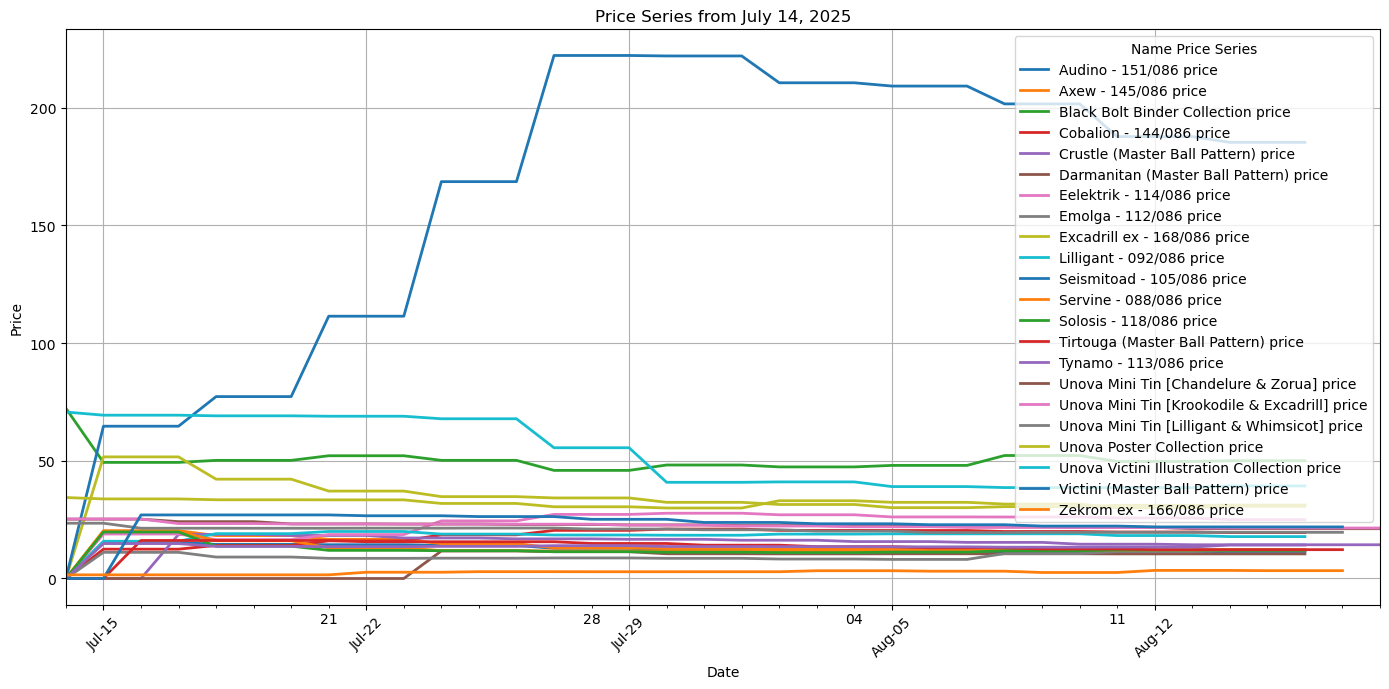

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Filter combined_df for dates >= 2025-07-14 (adjust year if needed)
start_date = pd.to_datetime("2025-07-14")
filtered_df = combined_df.loc[combined_df.index >= start_date]

# Select price columns
price_columns = [col for col in filtered_df.columns if col.endswith("price")]

# Plot
ax = filtered_df[price_columns].plot(figsize=(14, 7), linewidth=2)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Price Series from July 14, 2025')

# Format x-axis dates: show month-day e.g., Jul-15
date_fmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Optionally, set major tick locator to display ticks every few days or weeks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Name Price Series')
plt.tight_layout()
plt.show()


In [55]:
combined_df.columns

Index(['Audino - 151/086 price', 'Audino - 151/086 volume',
       'Axew - 145/086 price', 'Axew - 145/086 volume',
       'Black Bolt Binder Collection price',
       'Black Bolt Binder Collection volume', 'Cobalion - 144/086 price',
       'Cobalion - 144/086 volume', 'Crustle (Master Ball Pattern) price',
       'Crustle (Master Ball Pattern) volume',
       'Darmanitan (Master Ball Pattern) price',
       'Darmanitan (Master Ball Pattern) volume', 'Eelektrik - 114/086 price',
       'Eelektrik - 114/086 volume', 'Emolga - 112/086 price',
       'Emolga - 112/086 volume', 'Excadrill ex - 168/086 price',
       'Excadrill ex - 168/086 volume', 'Lilligant - 092/086 price',
       'Lilligant - 092/086 volume', 'Seismitoad - 105/086 price',
       'Seismitoad - 105/086 volume', 'Servine - 088/086 price',
       'Servine - 088/086 volume', 'Solosis - 118/086 price',
       'Solosis - 118/086 volume', 'Tirtouga (Master Ball Pattern) price',
       'Tirtouga (Master Ball Pattern) volume', 

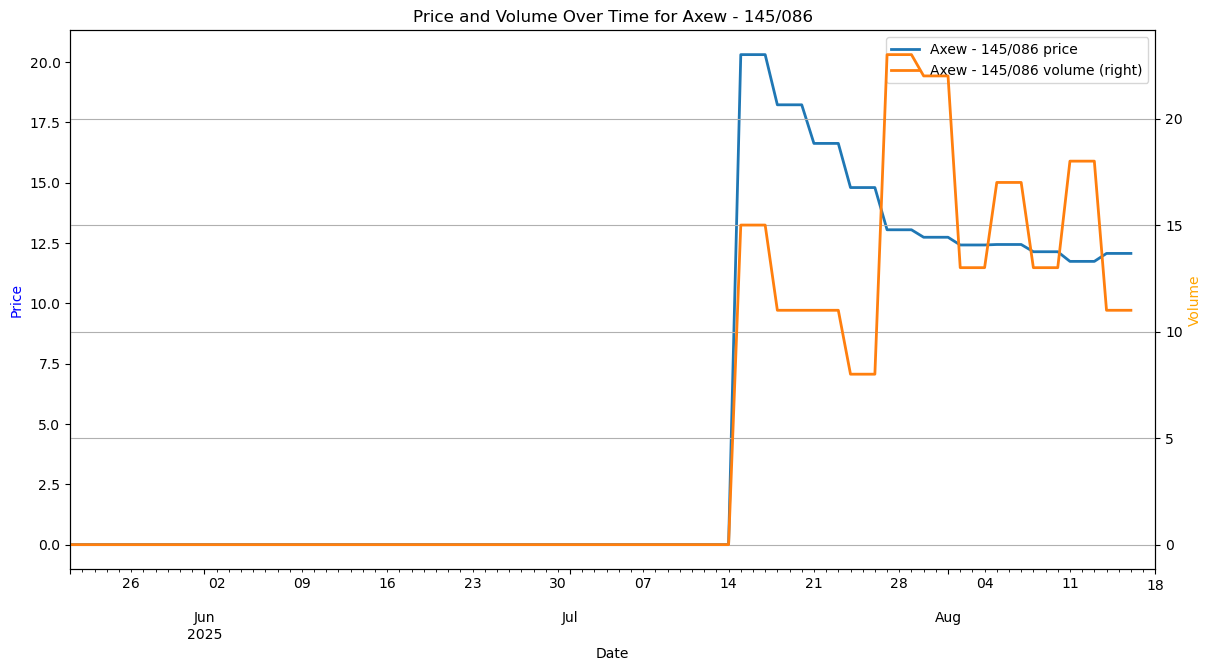

In [56]:
import matplotlib.pyplot as plt

# Replace with the name you want to plot
name_to_plot = "Axew - 145/086"

# Create the price and volume column names based on the pattern used in combined_df
price_col = f"{name_to_plot} price"
volume_col = f"{name_to_plot} volume"

# Filter columns - check if they exist in combined_df (avoid key errors)
cols_to_plot = [col for col in [price_col, volume_col] if col in combined_df.columns]

if cols_to_plot:
    ax = combined_df[cols_to_plot].plot(figsize=(14, 7), linewidth=2, secondary_y=volume_col)
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Price", color='blue')
    ax.right_ax.set_ylabel("Volume", color='orange')
    
    plt.title(f"Price and Volume Over Time for {name_to_plot}")
    plt.grid(True)
    plt.show()
else:
    print(f"Columns for '{name_to_plot}' not found.")


In [ ]:
# Add a new column for each name with the listings value
for name, listing in zip(filterdf['name'], filterdf['listings']):
    combined_df[f"{name} listings"] = listing

# Sort the columns in combined_df alphabetically
combined_df = combined_df.reindex(sorted(combined_df.columns), axis=1)

# Display the full DataFrame
print(combined_df)


            Audino - 151/086 listings  Audino - 151/086 price  \
date                                                            
2025-05-21                       52.0                    0.00   
2025-05-22                       52.0                    0.00   
2025-05-23                       52.0                    0.00   
2025-05-24                       52.0                    0.00   
2025-05-25                       52.0                    0.00   
...                               ...                     ...   
2025-08-14                       52.0                   11.48   
2025-08-15                       52.0                   11.48   
2025-08-16                       52.0                   11.48   
2025-08-17                       52.0                     NaN   
2025-08-18                       52.0                     NaN   

            Audino - 151/086 volume  Axew - 145/086 listings  \
date                                                           
2025-05-21                

In [62]:
# Create an empty dictionary to store results
screendf_dict = {}

# Get all product names from filterdf
product_names = filterdf['name'].tolist()

for name in product_names:
    vol_col = f"{name} volume"
    listing_col = f"{name} listings"

    if vol_col in combined_df.columns and listing_col in combined_df.columns:
        # Calculate rolling 10-day average volume, take the last value (most recent)
        recent_avg_vol = combined_df[vol_col].rolling(window=10, min_periods=1).mean().iloc[-1]
        
        # Get the static listing value (same for whole column)
        current_listing = combined_df[listing_col].iloc[0]

        screendf_dict[name] = {
            "10_day_avg_volume": recent_avg_vol,
            "current_listings": current_listing
        }
    else:
        screendf_dict[name] = {
            "10_day_avg_volume": None,
            "current_listings": None
        }

# Convert dictionary to DataFrame
screendf = pd.DataFrame.from_dict(screendf_dict, orient='index')

print(screendf)


                                         10_day_avg_volume  current_listings
Servine - 088/086                                19.000000              45.0
Axew - 145/086                                   14.125000              72.0
Tynamo - 113/086                                 14.875000              26.0
Dwebble - 129/086                                      NaN               NaN
Seismitoad - 105/086                              6.250000              48.0
Unova Victini Illustration Collection            63.625000             131.0
Unova Poster Collection                          31.375000             115.0
Black Bolt Binder Collection                     28.750000              93.0
Emolga - 112/086                                 24.250000              17.0
Audino - 151/086                                 17.125000              52.0
Solosis - 118/086                                16.625000              28.0
Eelektrik - 114/086                               9.125000              24.0